## Import Libraries & Import Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import timedelta

import optuna
from sklearn.model_selection import cross_val_score
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.svm import LinearSVR, SVR

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense

In [2]:
# Load data
df = pd.read_csv("data/Quarry Bay.csv", index_col = 0, header = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24936 entries, 0 to 24316
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RP      24936 non-null  float64
 1   GFA     24936 non-null  int64  
 2   AGE     24936 non-null  float64
 3   ZZ      24936 non-null  float64
 4   FL      24936 non-null  int64  
 5   FR      24936 non-null  int64  
 6   ROOF    24936 non-null  int64  
 7   CP      24936 non-null  int64  
 8   MTR     24936 non-null  int64  
 9   E       24936 non-null  int64  
 10  S       24936 non-null  int64  
 11  W       24936 non-null  int64  
 12  N       24936 non-null  int64  
 13  NE      24936 non-null  int64  
 14  SE      24936 non-null  int64  
 15  SW      24936 non-null  int64  
 16  NW      24936 non-null  int64  
dtypes: float64(3), int64(14)
memory usage: 3.4 MB


## 1. Exploratory Data Analysis

In [3]:
df['RP'].describe()

count    24936.000000
mean         4.063374
std          1.853626
min          0.440000
25%          2.997000
50%          3.594000
75%          4.576250
max         46.463000
Name: RP, dtype: float64

(array([3.5100e+02, 1.1252e+04, 8.6600e+03, 2.7390e+03, 1.2460e+03,
        3.4400e+02, 8.0000e+01, 9.9000e+01, 5.9000e+01, 3.0000e+01,
        4.3000e+01, 7.0000e+00, 8.0000e+00, 1.0000e+00, 1.0000e+00,
        3.0000e+00, 8.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.44  ,  1.9741,  3.5082,  5.0423,  6.5764,  8.1105,  9.6446,
        11.1787, 12.7128, 14.2469, 15.781 , 17.3151, 18.8492, 20.3833,
        21.9174, 23.4515, 24.9856, 26.5197, 28.0538, 29.5879, 31.122 ,
        32.6561, 34.1902, 35.7243, 37.2584, 38.7925, 40.3266, 41.8607,
        43.3948, 44.9289, 46.463 ]),
 <BarContainer object of 30 artists>)

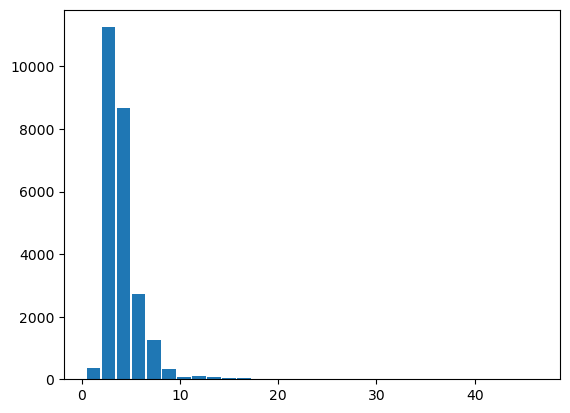

In [4]:
plt.hist(df['RP'], bins=30, rwidth=0.9)

Text(0.5, 0, 'RP')

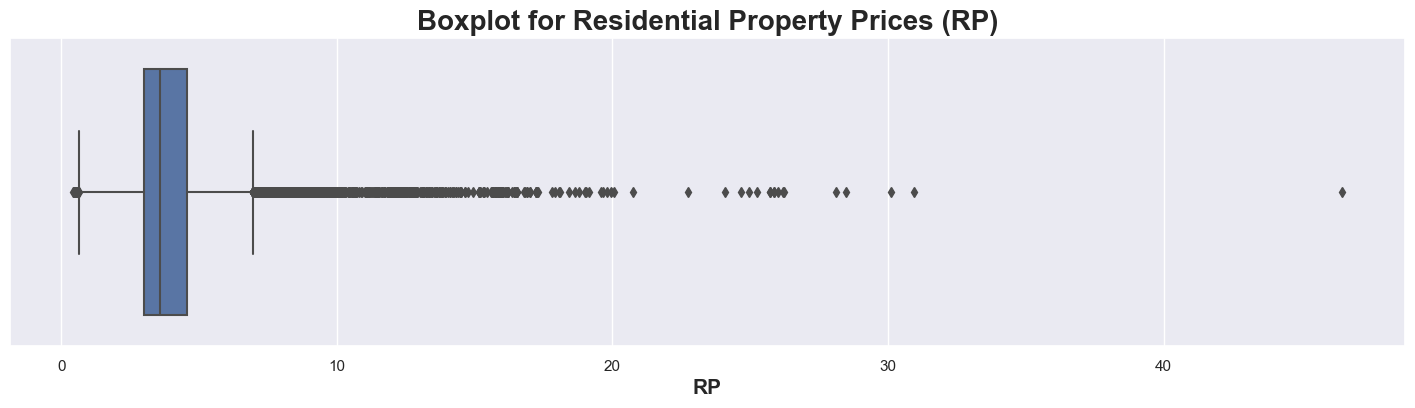

In [5]:
# Boxplot for RP
plt.figure(figsize = (18,4))
sns.set(style = 'darkgrid', palette = 'deep',)

sns.boxplot(x = "RP", data = df)
plt.title('Boxplot for Residential Property Prices (RP)', fontweight = 'bold', fontsize = '20', horizontalalignment = 'center') 
plt.xlabel('RP', fontweight = 'bold', fontsize = '15', horizontalalignment = 'center')

## 2. Data collection and preprocessing

### 2a. Create X and y, Split the train and test sets

In [6]:
# Keep features only for X
X = df.drop('RP', axis = 1)

# Keep target variable only for y
y = df[['RP']]

# Split the train test, here we are doing 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### 2b. Summary Statistics

In [7]:
display(X_train.head())
y_train.describe()

,GFA,AGE,ZZ,FL,FR,ROOF,CP,MTR,E,S,W,N,NE,SE,SW,NW
19950,752,27.34247,20561.53744,5,0,0,0,0,0,0,1,0,0,0,0,0
171,585,20.87123,12209.66955,22,0,0,0,1,0,0,1,0,0,0,0,0
17722,853,32.33699,27583.45247,4,0,0,0,1,1,0,0,0,0,0,0,0
499,675,28.60000,19305.00000,28,0,1,0,1,1,0,0,0,0,0,0,0
957,1029,13.30137,13687.10973,17,0,0,0,1,0,0,0,0,0,1,0,0


,RP
count,19948.000000
mean,4.060448
std,1.839071
min,0.447000
25%,2.997000
50%,3.591500
75%,4.578250
max,46.463000


In [8]:
display(X_test.head())
y_test.describe()

,GFA,AGE,ZZ,FL,FR,ROOF,CP,MTR,E,S,W,N,NE,SE,SW,NW
340,647,11.65479,7540.64913,3,0,0,0,0,0,1,0,0,0,0,0,0
8631,751,18.54247,13925.39497,10,0,0,0,1,0,1,0,0,0,0,0,0
21430,675,34.15068,23051.70900,23,0,0,0,1,0,0,1,0,0,0,0,0
18697,690,6.67945,4608.82050,63,0,0,0,1,0,0,0,0,0,0,0,1
3703,843,20.98082,17686.83126,24,0,0,0,1,1,0,0,0,0,0,0,0


,RP
count,4988.000000
mean,4.075076
std,1.910872
min,0.440000
25%,2.997750
50%,3.609000
75%,4.563000
max,28.491000


### 2c. Transform the X Dataset

In [9]:
# Transform the X Dataset

# Since the y dataset is only one varilable, there is no need to transform the dataset.
# Fit on the X_train using standard scaler, minmax scaler, robust scaler, or normalizer
# Then Transform X_train using same (standard scaler, minmax scaler, robust scaler, or normalizer) - save as X_train_sc
# and Transform X_test and save as X_test_sc

from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer, StandardScaler
sc = StandardScaler()
mm = MinMaxScaler()
rb = RobustScaler()
nm = Normalizer()


# fit the data i.e calculate the mean and sd of each coluns of X_train
sc.fit(X_train)

#transform the train data
X_train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)

#transform the test data
X_test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

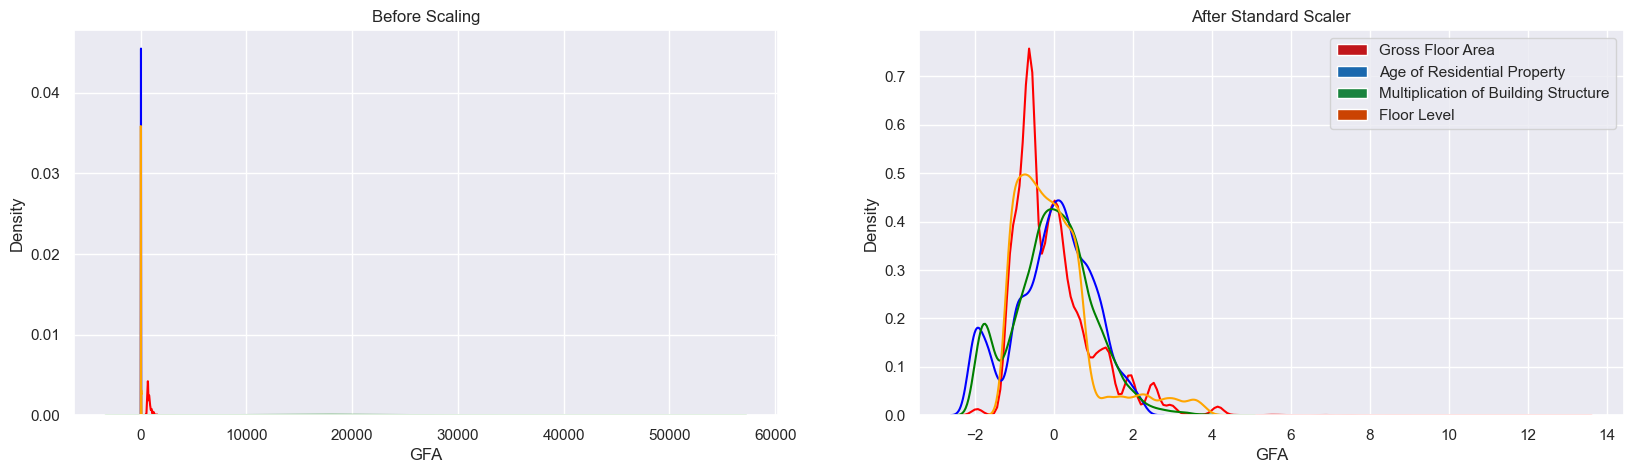

In [10]:
from sklearn.kernel_ridge import KernelRidge
import matplotlib.patches as  mpatches
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(X_train['GFA'],color="red", ax=ax1)
sns.kdeplot(X_train['AGE'],color="blue", ax=ax1)
sns.kdeplot(X_train['ZZ'],color="green", ax=ax1)
sns.kdeplot(X_train['FL'],color="orange", ax=ax1)


ax2.set_title('After Standard Scaler')
sns.kdeplot(X_train_sc['GFA'],color="red", ax=ax2)
sns.kdeplot(X_train_sc['AGE'],color="blue", ax=ax2)
sns.kdeplot(X_train_sc['ZZ'],color="green", ax=ax2)
sns.kdeplot(X_train_sc['FL'],color="orange", ax=ax2)

handles = [mpatches.Patch(facecolor=plt.cm.Reds(200), label='Gross Floor Area'),
           mpatches.Patch(facecolor=plt.cm.Blues(200), label='Age of Residential Property'),
           mpatches.Patch(facecolor=plt.cm.Greens(200), label='Multiplication of Building Structure'),
           mpatches.Patch(facecolor=plt.cm.Oranges(200), label='Floor Level')           
          ]
plt.legend(handles=handles)
plt.show()

#### Transformation is used for this dataset since the distributions before scalings are not normally distributed. The distributions after standard scalings are more comparable, and the features 'GFA', 'AGE', and 'ZZ' show bimodal shapes. The distritution of all features are skwed to the right. We will use 'X_train_sc' as 'X_train' and 'X_test_sc' as 'X_test' on building models.

In [11]:
X_train = X_train_sc
X_test = X_test_sc

In [12]:
len(X_train_sc)

19948

## 3. Kernel Ridge Regression
### 3a. Fit the model

In [13]:
# Define the objective function
def objective(trial):
    # Sample hyperparameters
    alpha = trial.suggest_uniform('alpha', 10, 20)
    gamma = trial.suggest_uniform('gamma', 0.1, 5)
    degree = 2  # Fixed degree since you're using a polynomial kernel

    # Create a Kernel Ridge Regression model
    Kridge = KernelRidge(alpha=alpha, kernel='polynomial', gamma=gamma, degree=degree)

    # Train the model
    Kridge.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = Kridge.predict(X_test)

    # Calculate the mean squared error for optimization
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [14]:
# Create and run the Optuna study
study = optuna.create_study(direction='minimize')  # We want to minimize the MSE
study.optimize(objective, n_trials=66)

# Get the best hyperparameters
best_params = study.best_params

# Create a Kernel Ridge Regression model with the best hyperparameters
alpha = best_params['alpha']
gamma = best_params['gamma']

Kridge = KernelRidge(
    alpha=alpha,
    kernel='polynomial',
    gamma=gamma,
    degree=2  # Fixed degree
)

Kridge.fit(X_train, y_train)
Kridge_pred = Kridge.predict(X_test)
y_hat_train = Kridge.predict(X_train)
y_hat_test_sc = Kridge_pred

[I 2023-11-15 08:10:52,290] A new study created in memory with name: no-name-77428834-04e4-46e8-8013-00dba952f4cb
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 10, 20)
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 5)
[I 2023-11-15 08:11:14,427] Trial 0 finished with value: 0.3755279586690108 and parameters: {'alpha': 16.37463633692691, 'gamma': 2.617319739670162}. Best is trial 0 with value: 0.3755279586690108.
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:4: Future

C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 10, 20)
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 5)
[I 2023-11-15 08:14:57,874] Trial 10 finished with value: 0.3753544057394311 and parameters: {'alpha': 10.172540793862336, 'gamma': 1.387081015705125}. Best is trial 2 with value: 0.37452256325091915.
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

[I 2023-11-15 08:18:40,274] Trial 20 finished with value: 0.37514476430105415 and parameters: {'alpha': 19.758168181658917, 'gamma': 0.14206962580078109}. Best is trial 12 with value: 0.37390993127577765.
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 10, 20)
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 5)
[I 2023-11-15 08:19:02,649] Trial 21 finished with value: 0.3739090865590674 and parameters: {'alpha': 17.559767188341564, 'gamma': 0.24166985133529617}. Best is trial 21 with value: 

C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 10, 20)
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 5)
[I 2023-11-15 08:22:43,383] Trial 31 finished with value: 0.3741728536609823 and parameters: {'alpha': 19.0106828652937, 'gamma': 0.3934390384295093}. Best is trial 21 with value: 0.3739090865590674.
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gith

[I 2023-11-15 08:26:23,464] Trial 41 finished with value: 0.3739772562544702 and parameters: {'alpha': 18.966974714566536, 'gamma': 0.3136539776300123}. Best is trial 21 with value: 0.3739090865590674.
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 10, 20)
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 5)
[I 2023-11-15 08:26:45,493] Trial 42 finished with value: 0.37468030979784833 and parameters: {'alpha': 18.871399853118632, 'gamma': 0.6659511599046104}. Best is trial 21 with value: 0.3

C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 10, 20)
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 5)
[I 2023-11-15 08:30:24,048] Trial 52 finished with value: 0.373913971080689 and parameters: {'alpha': 17.72867378958916, 'gamma': 0.2605240256745889}. Best is trial 21 with value: 0.3739090865590674.
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gith

[I 2023-11-15 08:34:03,724] Trial 62 finished with value: 0.376177168502206 and parameters: {'alpha': 16.40119944847391, 'gamma': 0.10982290311708581}. Best is trial 21 with value: 0.3739090865590674.
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 10, 20)
C:\Users\yingying.liu\AppData\Local\Temp\ipykernel_24196\955117.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.1, 5)
[I 2023-11-15 08:34:25,642] Trial 63 finished with value: 0.37456634688726265 and parameters: {'alpha': 16.884766256161758, 'gamma': 0.5467192267803906}. Best is trial 21 with value: 0.37

### 3b. Assess with the fitted model - Prediction accuracy in test data

In [15]:
# Calculate evaluation metrics
Kridgetest_mse = mean_squared_error(y_test, y_hat_test_sc)
Kridgetest_rmse = np.sqrt(Kridgetest_mse)
Kridgetest_mae = mean_absolute_error(y_test, y_hat_test_sc)
Kridgetest_r_squared = r2_score(y_test, y_hat_test_sc)
Kridgetest_mape = mean_absolute_percentage_error(y_test, y_hat_test_sc)

# Show best hyperparameters and evaluation metrics
print("Best Hyperparameters:", best_params)
print("Test MSE:", Kridgetest_mse)
print("Test RMSE:", Kridgetest_rmse)
print("Test MAE:", Kridgetest_mae)
print("Test R-squared:", Kridgetest_r_squared)
print("Test MAPE:", Kridgetest_mape) 

Best Hyperparameters: {'alpha': 17.559767188341564, 'gamma': 0.24166985133529617}
Test MSE: 0.3739090865590674
Test RMSE: 0.6114810598530975
Test MAE: 0.39897889765616973
Test R-squared: 0.897578772324282
Test MAPE: 0.12263915049365191


In [16]:
# Concatenate actual and predicted
# Create residual column for residual plot
df_Kridge_pred = pd.DataFrame(Kridge_pred, columns = ['Kridge_pred'])
Kridge_results = pd.DataFrame(y_test.reset_index())
df_results = pd.concat([Kridge_results, df_Kridge_pred], axis=1)
df_results['Kridge_resid'] = df_results['RP'] - df_Kridge_pred['Kridge_pred']

## 4. Support Vector Regression (SVR)

### 4a.  Fit the model

In [17]:
SVR_model = SVR()
def objective(trial):
    # Sample hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])
    C = trial.suggest_float('C', 13, 24, log=True)
    degree = trial.suggest_int('degree', 2, 5)
    
    # Create an SVR model with the suggested hyperparameters
    SVR_model = SVR(kernel=kernel, C=C, degree=degree)
    
    # Train the model
    SVR_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = SVR_model.predict(X_test)
    
    # Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

In [18]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')  # Minimize the MSE

# Start the optimization process
study.optimize(objective, n_trials=66)  # You can adjust the number of trials as needed

# Get the best hyperparameters and score
best_params = study.best_params
best_mse = -study.best_value  # Convert back to positive MSE

# Print the results
print('Best Support Vector Regression Hyperparameter Setting from Optuna:')
print('Support Vector Regression Config:', best_params)
print('Best Value for Mean Squared Error: {:.5f}'.format(best_mse))

[I 2023-11-15 08:35:34,677] A new study created in memory with name: no-name-93ee7671-52ae-46d5-8728-fe5f857a9a30
C:\Users\yingying.liu\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2023-11-15 08:35:56,481] Trial 0 finished with value: 0.3427580437200644 and parameters: {'kernel': 'rbf', 'C': 15.537492276886574, 'degree': 5}. Best is trial 0 with value: 0.3427580437200644.
C:\Users\yingying.liu\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2023-11-15 08:36:19,210] Trial 1 finished with value: 0.3444420395749394 and parameters: {'kernel': 'rbf', 'C': 

C:\Users\yingying.liu\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2023-11-15 08:58:49,410] Trial 17 finished with value: 0.34224402710554225 and parameters: {'kernel': 'rbf', 'C': 23.673526363532083, 'degree': 2}. Best is trial 14 with value: 0.3421208474776211.
C:\Users\yingying.liu\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2023-11-15 09:03:33,678] Trial 18 finished with value: 0.6245178409865395 and parameters: {'kernel': 'linear', 'C': 23.966579111456138, 'degree': 2}. Best is trial 14 with value: 0.3421208474776211.
C:\Users\yingying.liu\Ap

C:\Users\yingying.liu\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2023-11-15 09:14:54,207] Trial 34 finished with value: 0.3432264945933003 and parameters: {'kernel': 'rbf', 'C': 21.71622092547991, 'degree': 4}. Best is trial 31 with value: 0.34210889963800417.
C:\Users\yingying.liu\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2023-11-15 09:20:26,988] Trial 35 finished with value: 0.461235868671751 and parameters: {'kernel': 'poly', 'C': 22.252958498801068, 'degree': 4}. Best is trial 31 with value: 0.34210889963800417.
C:\Users\yingying.liu\AppDa

C:\Users\yingying.liu\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2023-11-15 09:39:09,647] Trial 51 finished with value: 0.34211126142027387 and parameters: {'kernel': 'rbf', 'C': 23.9742505938982, 'degree': 4}. Best is trial 36 with value: 0.3421086201511841.
C:\Users\yingying.liu\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2023-11-15 09:39:33,286] Trial 52 finished with value: 0.34244388685340216 and parameters: {'kernel': 'rbf', 'C': 23.304104111237056, 'degree': 4}. Best is trial 36 with value: 0.3421086201511841.
C:\Users\yingying.liu\AppDat

Best Support Vector Regression Hyperparameter Setting from Optuna:
Support Vector Regression Config: {'kernel': 'rbf', 'C': 23.99497092918475, 'degree': 3}
Best Value for Mean Squared Error: -0.34211


In [19]:
# Set the properties for SVR model
SVR_model = SVR(C = 23.99, kernel = 'rbf', degree = 3)

In [20]:
# Predicting the expected y for the testing data (y_test)
import warnings
warnings.filterwarnings("ignore")

SVR_model.fit(X_train, y_train)
SVR_pred = SVR_model.predict(X_test)
y_hat_test_sc = SVR_pred

### 4b. Assess with the fitted model - Prediction accuracy in test data

In [21]:
# Calculate evaluation metrics
SVRtest_mse = mean_squared_error(y_test, y_hat_test_sc)
SVRtest_rmse = np.sqrt(SVRtest_mse)
SVRtest_mae = mean_absolute_error(y_test, y_hat_test_sc)
SVRtest_r_squared = r2_score(y_test, y_hat_test_sc)
SVRtest_mape = mean_absolute_percentage_error(y_test, y_hat_test_sc)

# Show evaluation metrics
print("Test MSE:", SVRtest_mse)
print("Test RMSE:", SVRtest_rmse)
print("Test MAE:", SVRtest_mae)
print("Test R-squared:", SVRtest_r_squared)
print("Test MAPE:", SVRtest_mape) 

Test MSE: 0.34209120895791395
Test RMSE: 0.5848856375035327
Test MAE: 0.3401011941501386
Test R-squared: 0.9062943296698804
Test MAPE: 0.10904595960580585


In [22]:
# Concatenate actual and predicted
# Create residual column for residual plot
df_SVR_pred = pd.DataFrame(SVR_pred, columns = ['SVR_pred'])
df_results = pd.concat([df_results, df_SVR_pred], axis=1)
df_results['SVR_resid'] = df_results['RP'] - df_SVR_pred['SVR_pred']

## 5. Deep Neural Networks
### 5a.  Fit the model

In [23]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))  # Input layer
model.add(Dense(units=32, activation='relu'))  # Hidden layer
model.add(Dense(units=1, activation='linear'))  # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')

#Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Evaluate the model
y_pred = model.predict(X_test)

Epoch 1/100
624/624 [==============================] - 1s 770us/step - loss: 1.2721
Epoch 2/100
624/624 [==============================] - 1s 1ms/step - loss: 0.4515
Epoch 3/100
624/624 [==============================] - 0s 791us/step - loss: 0.4147
Epoch 4/100
624/624 [==============================] - 0s 791us/step - loss: 0.4012
Epoch 5/100
624/624 [==============================] - 1s 944us/step - loss: 0.3835
Epoch 6/100
624/624 [==============================] - 1s 923us/step - loss: 0.3738
Epoch 7/100
624/624 [==============================] - 1s 939us/step - loss: 0.3597
Epoch 8/100
624/624 [==============================] - 1s 926us/step - loss: 0.3463
Epoch 9/100
624/624 [==============================] - 1s 944us/step - loss: 0.3383
Epoch 10/100
624/624 [==============================] - 1s 945us/step - loss: 0.3375
Epoch 11/100
624/624 [==============================] - 1s 921us/step - loss: 0.3314
Epoch 12/100
624/624 [==============================] - 1s 935us/step - loss

In [24]:
# Calculate evaluation metrics
DNNtest_mse = mean_squared_error(y_test, y_pred)
DNNtest_rmse = np.sqrt(DNNtest_mse)
DNNtest_mae = mean_absolute_error(y_test, y_pred)
DNNtest_r_squared = r2_score(y_test, y_pred)
DNNtest_mape = mean_absolute_percentage_error(y_test, y_pred)

# Show evaluation metrics
print("Test MSE:", DNNtest_mse)
print("Test RMSE:", DNNtest_rmse)
print("Test MAE:", DNNtest_mae)
print("Test R-squared:", DNNtest_r_squared)
print("Test MAPE:", DNNtest_mape) 

Test MSE: 0.32155800723185257
Test RMSE: 0.5670608496729893
Test MAE: 0.34286618948173986
Test R-squared: 0.9119187870700729
Test MAPE: 0.10914987300338386


### 5b. Assess with the fitted model - Prediction accuracy in test data

In [25]:
# Predicting the expected y for the testing data (y_test)
DNN_pred = y_pred

# Concatenate actual and predicted
# Create residual column for residual plot
df_DNN_pred = pd.DataFrame(DNN_pred, columns = ['DNN_pred'])
df_results = pd.concat([df_results, df_DNN_pred], axis=1)
df_results['DNN_resid'] = df_results['RP'] - df_DNN_pred['DNN_pred']

## 6. Analyze the Residuals for KRR, SVR, DNN

<Figure size 2400x1000 with 0 Axes>

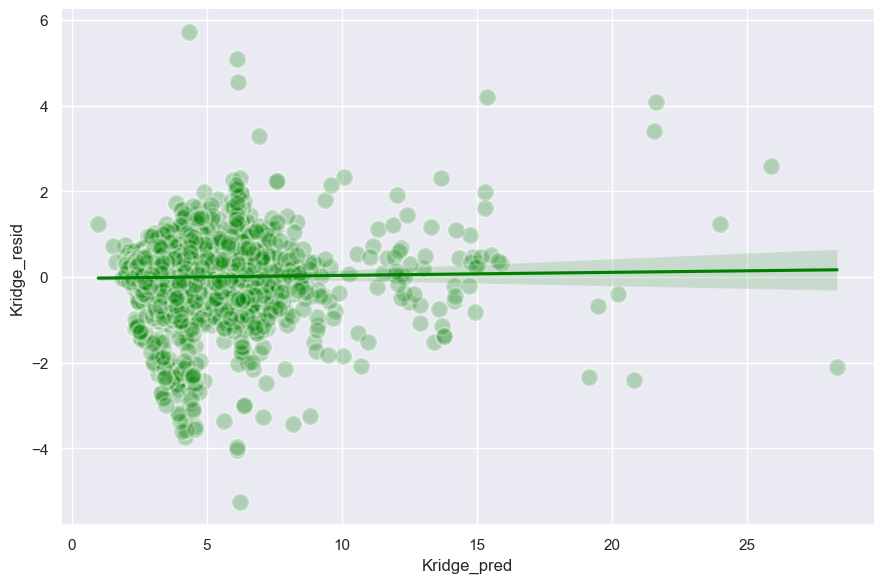

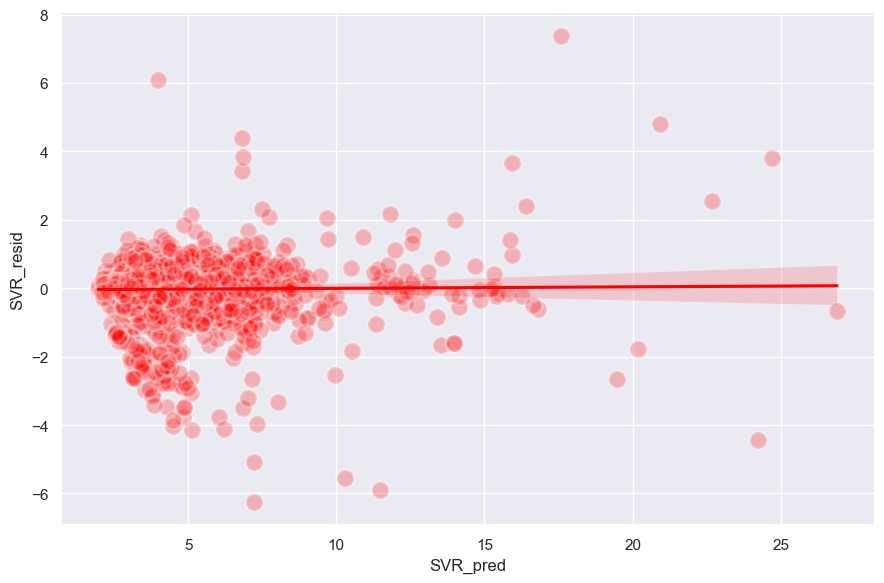

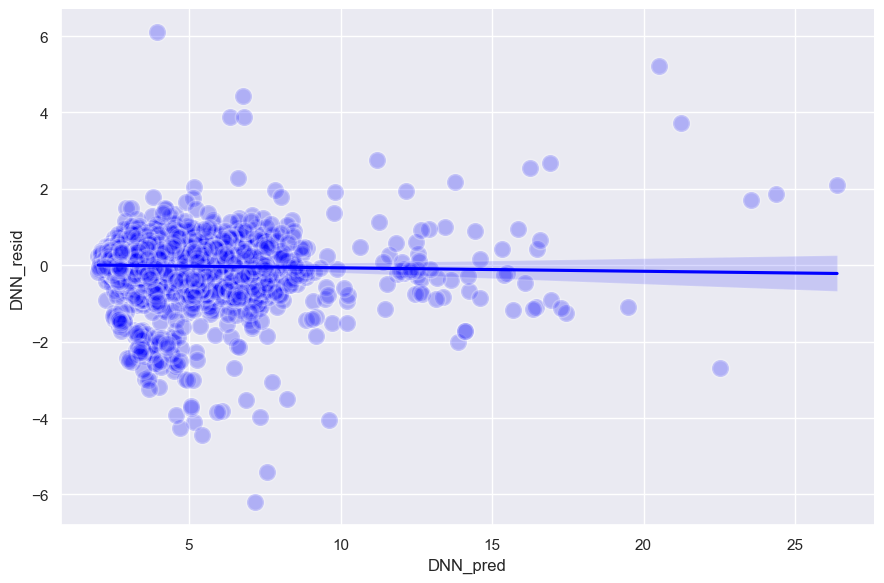

In [26]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(24,10)) #changes area of scatterplot

sns.lmplot(x='Kridge_pred', y='Kridge_resid', data = df_results, height=6,
           aspect = 1.5, scatter_kws={"alpha":0.25,"s":150,"linewidth":2,"color":"green","edgecolor":"white"}, line_kws={'color': 'green'})
sns.lmplot(x='SVR_pred', y='SVR_resid', data = df_results, height=6,
           aspect = 1.5, scatter_kws={"alpha":0.25,"s":150,"linewidth":2,"color":"red","edgecolor":"white"}, line_kws={'color': 'red'})

sns.lmplot(x='DNN_pred', y='DNN_resid', data = df_results, height=6,
           aspect = 1.5, scatter_kws={"alpha":0.25,"s":150,"linewidth":2,"color":"blue","edgecolor":"white"}, line_kws={'color': 'blue'})

## 7. Comparisons - Differences between KRR, SVR, and DNN

In [27]:
# Data Restracture

df_resid_melt = pd.melt(df_results, id_vars=['index'], \
                 value_vars=['Kridge_resid','SVR_resid', 'DNN_resid'])
df_resid_melt = df_resid_melt.rename(columns = {'value':'Residual'})
df_pred_melt  = pd.melt(df_results, id_vars=['index', 'RP'], \
                 value_vars=['Kridge_pred','SVR_pred', 'DNN_pred'])
df_pred_melt  = df_pred_melt.rename(columns = {'variable': 'Reg_Type', 'value':'Prediction'})
df_pred_melt['Reg_Type'] = df_pred_melt.Reg_Type.str.replace('_pred', '')
df_pred_resid = pd.concat([df_pred_melt, df_resid_melt['Residual']], axis=1)
df_pred_resid.head()

,index,RP,Reg_Type,Prediction,Residual
0,340,2.546,Kridge,2.449026,0.096974
1,8631,1.434,Kridge,3.586528,-2.152528
2,21430,3.524,Kridge,3.292886,0.231114
3,18697,3.892,Kridge,4.489075,-0.597075
4,3703,4.558,Kridge,4.493661,0.064339


In [29]:
# Display df_results
df_results['Kridge_resid_abs'] = abs(df_results['Kridge_resid'])
df_results['SVR_resid_abs']    = abs(df_results['SVR_resid'])
df_results['DNN_resid_abs']  = abs(df_results['DNN_resid'])
df_results.head()

,index,RP,Kridge_pred,Kridge_resid,SVR_pred,SVR_resid,DNN_pred,DNN_resid,Kridge_resid_abs,SVR_resid_abs,DNN_resid_abs
0,340,2.546,2.449026,0.096974,2.633709,-0.087709,2.470065,0.075935,0.096974,0.087709,0.075935
1,8631,1.434,3.586528,-2.152528,3.521077,-2.087077,3.552365,-2.118365,2.152528,2.087077,2.118365
2,21430,3.524,3.292886,0.231114,3.401651,0.122349,3.459676,0.064324,0.231114,0.122349,0.064324
3,18697,3.892,4.489075,-0.597075,4.039421,-0.147421,4.086825,-0.194825,0.597075,0.147421,0.194825
4,3703,4.558,4.493661,0.064339,4.477718,0.080282,4.559163,-0.001163,0.064339,0.080282,0.001163


In [30]:
# Three models residual summary statistics comparison 
df_results[['Kridge_resid', 'SVR_resid', 'DNN_resid', 'Kridge_resid_abs','SVR_resid_abs','DNN_resid_abs',]].describe()

,Kridge_resid,SVR_resid,DNN_resid,Kridge_resid_abs,SVR_resid_abs,DNN_resid_abs
count,4988.000000,4988.000000,4988.000000,4988.000000,4988.000000,4988.000000
mean,-0.006361,-0.030227,-0.014288,0.398979,0.340101,0.342866
std,0.611509,0.584163,0.566938,0.463431,0.475886,0.451710
min,-5.246936,-6.242249,-6.188341,0.000067,0.000024,0.000102
25%,-0.268081,-0.217010,-0.203149,0.128266,0.093285,0.101915
50%,0.029075,0.000997,0.030364,0.282308,0.216630,0.227801
75%,0.292897,0.216102,0.243785,0.495979,0.411360,0.418949
max,5.708676,7.357775,6.095107,5.708676,7.357775,6.188341


In [31]:
df_results_T = df_results[['Kridge_resid','SVR_resid','DNN_resid','Kridge_resid_abs', 'SVR_resid_abs', 'DNN_resid_abs']].T
minResid = df_results_T.min()
minResid = pd.DataFrame(minResid.T, columns = ['resid_min'])
df_results = pd.concat([df_results, minResid], axis=1)
df_results.head()

,index,RP,Kridge_pred,Kridge_resid,SVR_pred,SVR_resid,DNN_pred,DNN_resid,Kridge_resid_abs,SVR_resid_abs,DNN_resid_abs,resid_min
0,340,2.546,2.449026,0.096974,2.633709,-0.087709,2.470065,0.075935,0.096974,0.087709,0.075935,-0.087709
1,8631,1.434,3.586528,-2.152528,3.521077,-2.087077,3.552365,-2.118365,2.152528,2.087077,2.118365,-2.152528
2,21430,3.524,3.292886,0.231114,3.401651,0.122349,3.459676,0.064324,0.231114,0.122349,0.064324,0.064324
3,18697,3.892,4.489075,-0.597075,4.039421,-0.147421,4.086825,-0.194825,0.597075,0.147421,0.194825,-0.597075
4,3703,4.558,4.493661,0.064339,4.477718,0.080282,4.559163,-0.001163,0.064339,0.080282,0.001163,-0.001163


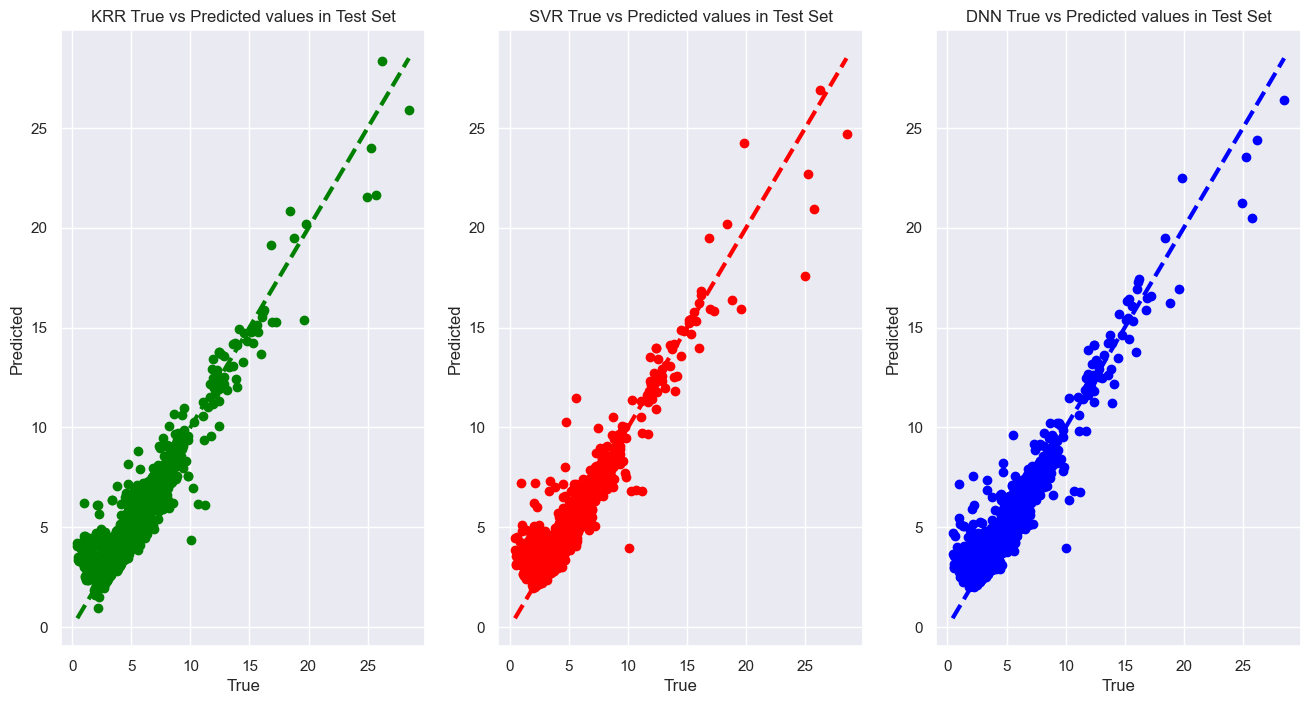

In [32]:
fig = plt.figure(figsize=(16, 8))

plt.subplot(131)
plt.plot(y_test, Kridge_pred, "o", color = "green")
identity_line = np.linspace(min(np.asarray(y_test, dtype='float64')), max(np.asarray(y_test, dtype='float64')), 100)
plt.plot(identity_line, identity_line, color="green", linestyle="dashed", linewidth=3.0)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("KRR True vs Predicted values in Test Set")

plt.subplot(132)
plt.plot(y_test, SVR_pred, "o", color = "red")
identity_line = np.linspace(min(np.asarray(y_test, dtype='float64')), max(np.asarray(y_test, dtype='float64')), 100)
plt.plot(identity_line, identity_line, color="red", linestyle="dashed", linewidth=3.0)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("SVR True vs Predicted values in Test Set")

plt.subplot(133)
plt.plot(y_test, DNN_pred, "o", color = "blue")
identity_line = np.linspace(min(np.asarray(y_test, dtype='float64')), max(np.asarray(y_test, dtype='float64')), 100)
plt.plot(identity_line, identity_line, color="blue", linestyle="dashed", linewidth=3.0)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("DNN True vs Predicted values in Test Set")

plt.show()



In [33]:
# Define Regression Type by finding the minimum residuals

def bestreg(c):
    if c['Kridge_resid_abs'] == c['resid_min']:
        return 'Kridge'
    elif c['SVR_resid_abs'] == c['resid_min']:
        return 'SVR'  
    else: 
        return 'DNN'    

In [34]:
# Final Comaprison Table
df_results['best_reg'] = df_results.apply(bestreg, axis=1)

classifiers = ['KRR', 'SVR', 'DNN']
mse_values = [Kridgetest_mse, SVRtest_mse, DNNtest_mse]
rmse_values = [Kridgetest_rmse, SVRtest_rmse, DNNtest_rmse]
mae_values = [Kridgetest_mae, SVRtest_mae, DNNtest_mae]
r_squared_values = [Kridgetest_r_squared, SVRtest_r_squared, DNNtest_r_squared]
mape_values = [Kridgetest_mape, SVRtest_mape, DNNtest_mape]

results = {
    'Model': classifiers,
    'MSE': mse_values,
    'R_Sq': r_squared_values,
    'RMSE': rmse_values,
    'MAE': mae_values,
    'MAPE': mape_values,
}

df_compare = pd.DataFrame(results)
df_compare

,Model,MSE,R_Sq,RMSE,MAE,MAPE
0,KRR,0.373909,0.897579,0.611481,0.398979,0.122639
1,SVR,0.342091,0.906294,0.584886,0.340101,0.109046
2,DNN,0.321558,0.911919,0.567061,0.342866,0.109150
